# Using behavior to predict neural activity

These groups of neurons that are not stimulus-selective, what are they doing? Maybe they are related to the behavior of the mouse?

If that's the case we need some low-dimensional representation of the behavior - we can't predict using 1 million pixels of video data - that's an underconstrained problem.

# 1. Load in data + behavior

In [3]:
# this cell imports all the functions we need
import os # os stands for "operating system" and includes read/write routines etc. 
import numpy as np # by far the most used library for everyday computation
from scipy import io # this is for importing Matlab data files
from scipy import stats # here we import a whole sub-library of stats functions
from scipy.ndimage import gaussian_filter # here we import a single function
from sklearn.decomposition import PCA # check out all the other dimensionality reduction methods in "decomposition"
from matplotlib import pyplot as plt # all of our plotting is done with plt
from scipy.stats import zscore
%matplotlib inline 

# NEURAL DATA 
# folder where data is 
root = '/home/neuraldata/data/meso/'
mouse_name = 'TX39'

spks = np.load(os.path.join(root, mouse_name, 'suite2p/combined/spks.npy'))
stat = np.load(os.path.join(root, mouse_name, 'suite2p/combined/stat.npy'), allow_pickle=True)
# these are the neurons' 2D coordinates
ypos = [stat[n]['med'][0] for n in range(len(stat))] 
xpos = [stat[n]['med'][1] for n in range(len(stat))] 

print('total neurons %d'%len(stat))

S = zscore(spks,axis=1)
del spks

total neurons 18795


Load in behavioral data

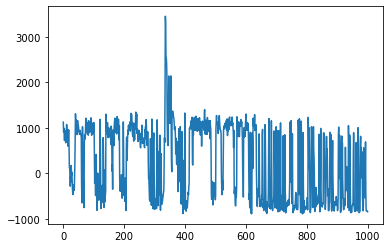

In [5]:
# BEHAVIORAL DATA
proc   = np.load(os.path.join(root, mouse_name, 'cam1_TX39_2019_05_31_1_proc_resampled.npy'), allow_pickle=True).item()
motSVD = proc['motSVD']
parea  = proc['pupil']['area'][0].copy()

plt.plot(motSVD[0,:1000]*-1)
plt.show()

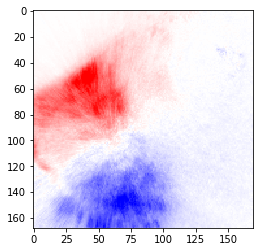

In [19]:
# explore "proc", look at ".keys()"
proc.keys()
plt.imshow(proc['motMask'][1], cmap='bwr', vmin=-.02, vmax=.02)

# Bin neural and behavioral data + compute neural PCA

We will bin the neural activity to do the PCA and the behavior (1 second bins)

In [4]:
# bin data
tbin = int(3)
NT = motSVD.shape[1]
nt = int(np.floor(NT/tbin))
motSVD -= motSVD.mean(axis=1)[:,np.newaxis]
parea  -= np.nanmean(parea)
parea[np.isnan(parea)] = 0

beh = np.reshape(motSVD[:,:nt*tbin], (motSVD.shape[0], nt, tbin)).mean(axis=-1)
pup = np.reshape(parea[:nt*tbin], (nt, tbin)).mean(axis=-1)

# using this format bin S
# Sbin = ?
Sbin = np.reshape(S[:,:nt*tbin], (S.shape[0], nt, tbin)).mean(axis=-1)

Take principal components of neural data (as previously)

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=256).fit(Sbin)
V = pca.components_ # time components
sv = pca.singular_values_
U = np.matmul(Sbin,V.T) / sv # neuron components
V *= sv[:,np.newaxis]


# Prediction of neural PCs

Now let's predict these neural PC's using our behavioral measures. But FIRST we need to split the data into train and test segments.

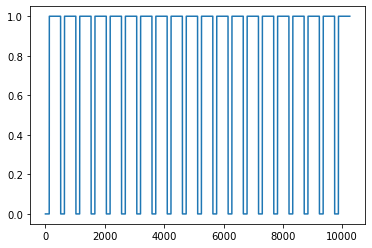

In [6]:
# split into train-test
# * use interleaved segments *
nsegs = 20
nlen  = nt/nsegs
ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
itrain = np.ones(nt, np.bool)
itrain[itest] = 0

plt.plot(itrain)
plt.show()

Can you determine how I did the split above? Why might I have split into segments rather than randomly interleaving time-points?

# Prediction with behavioral variables

Use linear regression to perform the prediction, predict $Y$ using $X$:

$$ A = (X_\text{train}X_\text{train}^\top)^{-1} (X_\text{train} Y_\text{train}^\top)$$

$X$ is behavioral components by time, $Y$ is neural components by time. If you want to regularize the linear regression:

$$ A = (X_\text{train}X_\text{train}^\top + \lambda I)^{-1} (X_\text{train} Y_\text{train}^\top)$$

Then the prediction on time points is:

$$ \hat Y_\text{test} = A^\top X_\text{test} $$

In [7]:
#### PREDICT USING PUPIL WITH LINEAR REGRESSION

A = np.matmul(pup[itrain], V[:,itrain].T)/(pup**2).sum()

Vpredp = np.matmul(A[:,np.newaxis], pup[itest][np.newaxis,:])

varexp_pupil = 1 - ((Vpredp - V[:,itest])**2).sum(axis=1)/(V[:,itest]**2).sum(axis=1)

In [8]:
#### PREDICT USING BEHAVIOR PC'S 

## regularized linear regression from behavior to neural PC's
covM = np.matmul(beh[:,itrain], beh[:,itrain].T)
lam = 1e6 # regularizer
covM += lam*np.eye(beh.shape[0])
A = np.linalg.solve(covM, np.matmul(beh[:,itrain], V[:,itrain].T))

Vpred = np.matmul(A.T, beh[:,itest])

varexp = 1 - ((Vpred - V[:,itest])**2).sum(axis=1)/(V[:,itest]**2).sum(axis=1)

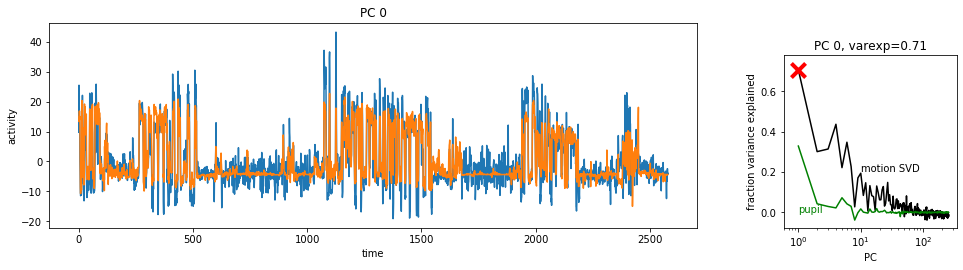

In [70]:
# plot of principal component activity and variance explained

fig=plt.figure(figsize=(12,3))

ipc = 0 ### which PC to plot

ax = fig.add_axes([0.05,.05,.75,.95])
ax.plot(V[ipc,itest])
ax.plot(Vpred[ipc])
ax.set_title('PC %d'%ipc)
ax.set_xlabel('time')
ax.set_ylabel('activity')

ax = fig.add_axes([0.9,.05, .2, .8])
ax.semilogx(np.arange(1,varexp.size+1), varexp, color='k')
ax.scatter(ipc+1, varexp[ipc],marker='x',color='r',s=200, lw=4, zorder=10)
ax.semilogx(np.arange(1,varexp.size+1), varexp_pupil, color=[0.,.5,0])
ax.text(1,0,'pupil',color=[0,.5,0])
ax.text(10,0.2,'motion SVD')
ax.set_xlabel('PC')
ax.set_ylabel('fraction variance explained')
ax.set_title('PC %d, varexp=%0.2f'%(ipc,varexp[ipc]))
plt.show()

# Sort neurons with rastermap

Let's see how well the behavioral prediction "looks". First let's sort the neural activity by rastermap, then use the sorting to sort the prediction of the neural activity.

In [11]:
# make sorting of neurons with rastermap
from rastermap import Rastermap

model = Rastermap(n_components=1, n_X=100).fit(S)

nmin 200
1.105116367340088
25.151588678359985
26.335423707962036
26.397257566452026
(98, 100)
(130,)
1.0
time; iteration;  explained PC variance
0.45s     0        0.0266      2
1.07s    10        0.0992      4
1.74s    20        0.1377      8
2.38s    30        0.1763      18
3.02s    40        0.2060      28
3.66s    50        0.2260      38
4.29s    60        0.2434      48
4.94s    70        0.2558      58
5.52s    80        0.2666      68
6.14s    90        0.2759      78
6.72s    100        0.2858      88
7.39s    110        0.2961      98
8.02s    120        0.2976      98
8.58s   final      0.2977
8.60s upsampled    0.2977


Now let's sort by rastermap and smooth over neurons

In [12]:
# SMOOTHED NEURAL ACTIVITY
# this function performs a running average filter over the first dimension of X
def running_average(X, nbin = 100):
    Y = np.cumsum(X, axis=0)
    Y = Y[nbin:, :] - Y[:-nbin, :]
    return Y

isort = np.argsort(model.embedding[:,0])

Sfilt = running_average(Sbin[isort,:])
Sfilt = zscore(Sfilt, axis=1)

Let's sort the behavioral prediction by rastermap and smooth over neurons.

In [13]:
# BEHAVIOR PREDICTION

Spred = np.matmul(U, Vpred)
Sfilt_pred = running_average(Spred[isort, :])
Sfilt_pred = zscore(Sfilt_pred, axis=1)

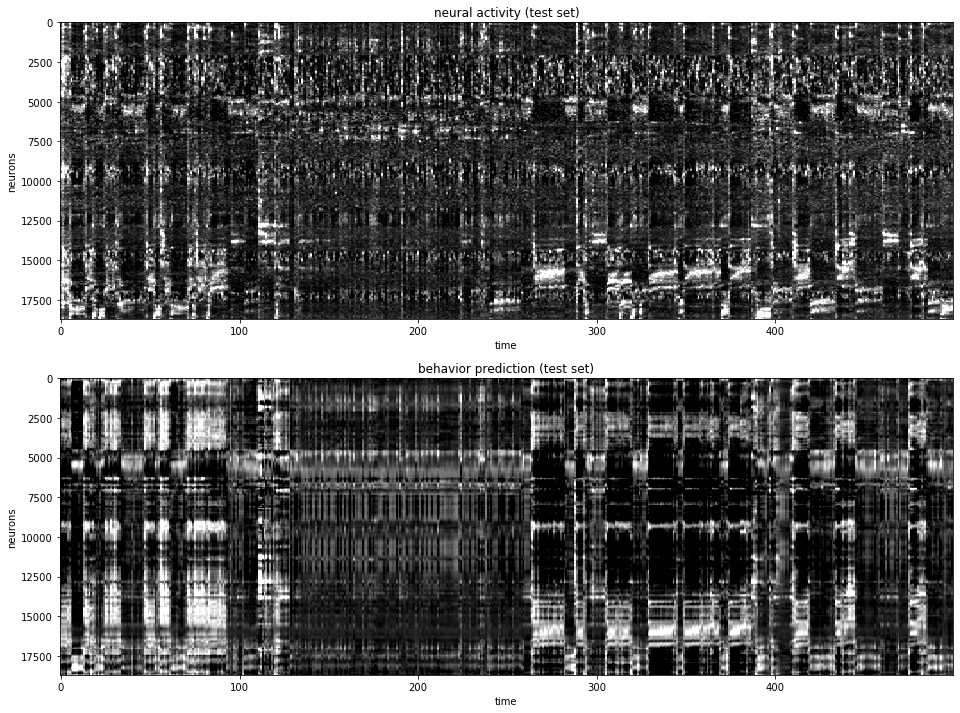

In [15]:
# plot with activity + prediction

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(2,1,1)
ax.imshow(Sfilt[:,itest[:500]], vmin = -1, vmax=3, aspect='auto', cmap = 'gray')
ax.set_xlabel('time')
ax.set_ylabel('neurons')
ax.set_title('neural activity (test set)')

ax = fig.add_subplot(2,1,2)
ax.imshow(Sfilt_pred[:,:500], vmin = -1, vmax=3, aspect='auto', cmap = 'gray')
ax.set_xlabel('time')
ax.set_ylabel('neurons')
ax.set_title('behavior prediction (test set)')

plt.show()

In [53]:
# how good is the prediction across the rastermap?

# bin across the rastermap in groups of 100 neurons
ng = 500
nn = int(isort.size / ng)

neurbin = np.reshape(Sbin[np.ix_(isort, itest)][:nn*ng,:], (nn, ng, -1)).mean(axis=1)
neurbin_pred = np.reshape(Spred[isort, :][:nn*ng,:], (nn, ng, -1)).mean(axis=1)

neurbin = zscore(neurbin, axis=1)
neurbin_pred = zscore(neurbin_pred, axis=1)

cc = np.matmul(neurbin, neurbin_pred.T) / neurbin.shape[-1]

cpred = np.diag(cc)

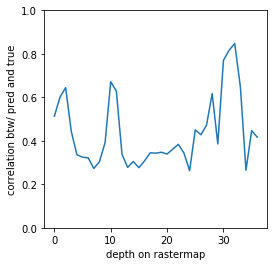

In [59]:
# prediction quality across the rastermap

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1,1,1)
ax.plot(cpred)
ax.set_ylim([0,1])
ax.set_ylabel('correlation btw/ pred and true')
ax.set_xlabel('depth on rastermap')
plt.show()